## Plotting WMS layers with Cartopy ##

### Introduction ###

WMS (Web Map Service) is an OGC (Open Geospatial Consortium) standard for requesting geo-located map images over HTTP. The OGC provide a [detailed overview](http://www.opengeospatial.org/standards/wms) of the WMS standard.

A WMS request to a WMS server contains layer (a map layer containing a given geographic phenomenon) and area of interest information. The information in the request defines the response from the WMS server to which the request was made. The response is composed of geo-located map images that can be displayed by the application making the request.

The map images in a WMS response are raster images, typically provided in `PNG` or `JPEG` format.

An important part of OGC standards services is the `get capabilities` request. This returns an XML document that specifies the capabilities (metadata) about the service. Information included in the get capabilities response includes:

<ul>
<li>supported operations,</li>
<li>supported parameters, and</li>
<li>available layers.</li>
</ul>

**This notebook** demonstrates using Cartopy to:

<ul>
<li>make WMS requests,</li>
<li>plot the images in the response from the WMS requests,</li>
<li>add value to the plot with locations of points of interest,</li>
<li>add value to the plot with data from Iris cubes, and</li>
<li>transform the plot into a new projection.</li>
</ul>

### Plotting WMS response images ###

Let's demonstrate making an WMS request with Cartopy and plotting the map image contained in the response. Let's use data from the **CONUS GOES IR Satellite** (see http://www.goes.noaa.gov/sat-explanation.html for more detail) exposed as a WMS service.

To make a WMS request in Cartopy, as with every WMS request, we provide a URL to a WMS server. This server provides a web map service, which may provide one or more layers of geographic phenomena. To complete the request we need to also provide the name of the layer we're interested in. To find the names of the available layers we need to refer to the get capabilities response from the WMS server.

We can use the Python library [`OWSLib`](http://geopython.github.io/OWSLib/) to retrieve this information from the get capabilities response from the WMS server:

In [1]:
from owslib.wms import WebMapService

url = 'http://mesonet.agron.iastate.edu/cgi-bin/wms/goes/conus_ir.cgi?'
wms = WebMapService(url)
layers = list(wms.contents)
print(f'Request type: {wms.identification.type}')
print(f'Request title: {wms.identification.title}')
print(f'Available layers: {layers}')

Request type: OGC:WMS
Request title: IEM GOES IR WMS Service
Available layers: ['goes_conus_ir', 'conus_ir_4km']


Let's take a more in-depth look at a layer of interest:

In [2]:
layer = layers[1]

print(f'Layer title: {wms[layer].title}')
print(f'Bounding box: {wms[layer].boundingBoxWGS84}')
print(f'Projection: {wms[layer].crsOptions}')

Layer title: conus_ir_4km
Bounding box: (-152.110808, 14.561815, -52.918301, 56.780247)
Projection: ['EPSG:4326', 'EPSG:3857']


Making a WMS request is completely handled by Cartopy behind the scenes. The above examples are just to demonstrate finding layer names and other useful information contained in a WMS response.

With this information from the get capabilities to hand we can construct a WMS request. Let's import some more useful libraries and define a convenience function that returns a common set of axes onto which to plot our WMS layer and other data.

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

us_extent = [-126.0, -66.0, 24.0, 50.0]

def set_up_axes(proj, coast_colour='r', extent=us_extent):
    fig = plt.figure(figsize=(14, 9))
    ax = plt.axes(projection=proj)
    ax.coastlines(color=coast_colour)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    return ax

Let's set up some axes and use Cartopy to plot the image response from a WMS request to the axes.

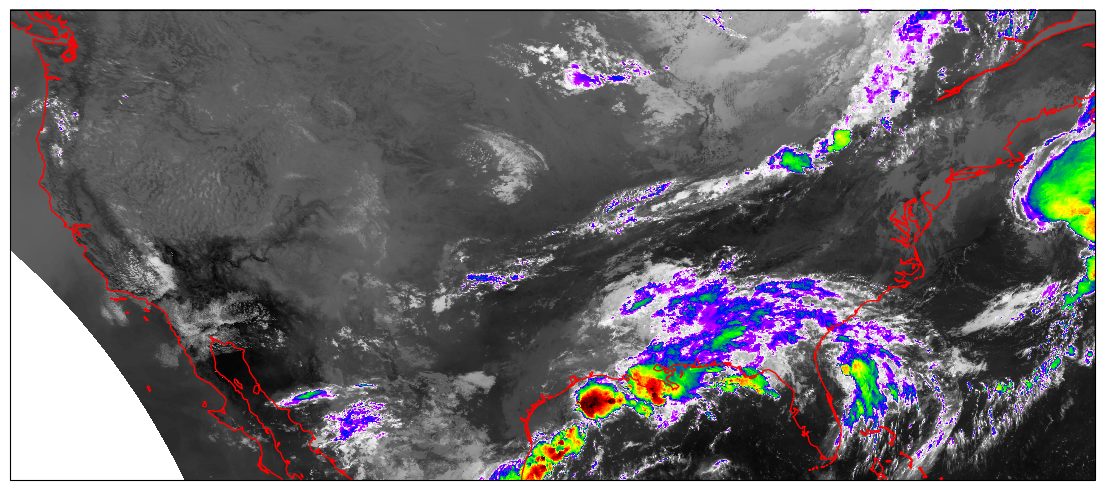

In [4]:
proj = ccrs.PlateCarree()
ax = set_up_axes(proj)

ax.add_wms(url, layer)

plt.show()

### Adding value ###

We can add value to our plot above by adding data to it. For example, we can add the location of major US cities to the plot and add air temperature data taken from an Iris cube.

#### Adding city locations ####

Let's add the locations of three US cities to the plot, along with a text label of the city's name:

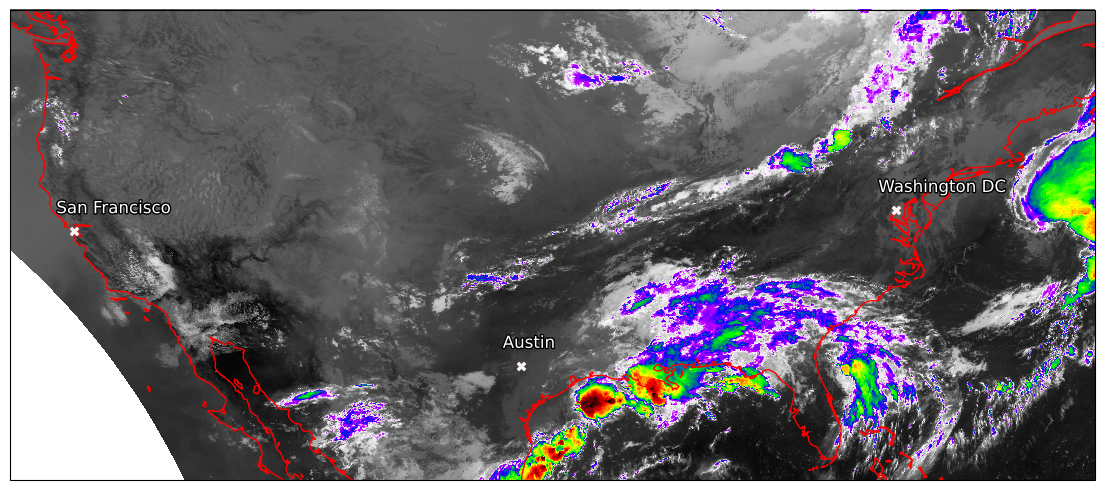

In [5]:
import matplotlib.patheffects as mpath

# Set up the axes and add a WMS layer, as above.
proj = ccrs.PlateCarree()
ax = set_up_axes(proj)

ax.add_wms(url, layer)

# Add the locations of our three cities.
cities = {'Washington DC': [38.928, -76.981],
          'Austin': [30.308, -97.753],
          'San Francisco': [37.758, -122.438],}
city_white = '#fff3f3'

for name, latlon in cities.items():
    plt.scatter(latlon[1], latlon[0], c=city_white, s=50, linewidths=0, marker='X', zorder=99)
    plt.text(latlon[1]-1.0, latlon[0]+1.0, name, color='w', size=12,
             path_effects=[mpath.withStroke(linewidth=2, foreground='k')])

plt.show()

#### Adding data from an Iris cube ####

The Iris sample data contains data on the predicted yearly average air temperature over the US according to the A1B scenario. Let's add the predicted air temperature for 2015 to the plot:

In [6]:
import iris
import iris.quickplot as qplt

year_2015 = iris.Constraint(time=lambda cell: cell.point.year == 2015)
cube = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'), year_2015)

For more information on constrained loading of Iris cubes, see http://scitools.org.uk/iris/docs/latest/userguide/loading_iris_cubes.html#constrained-loading.

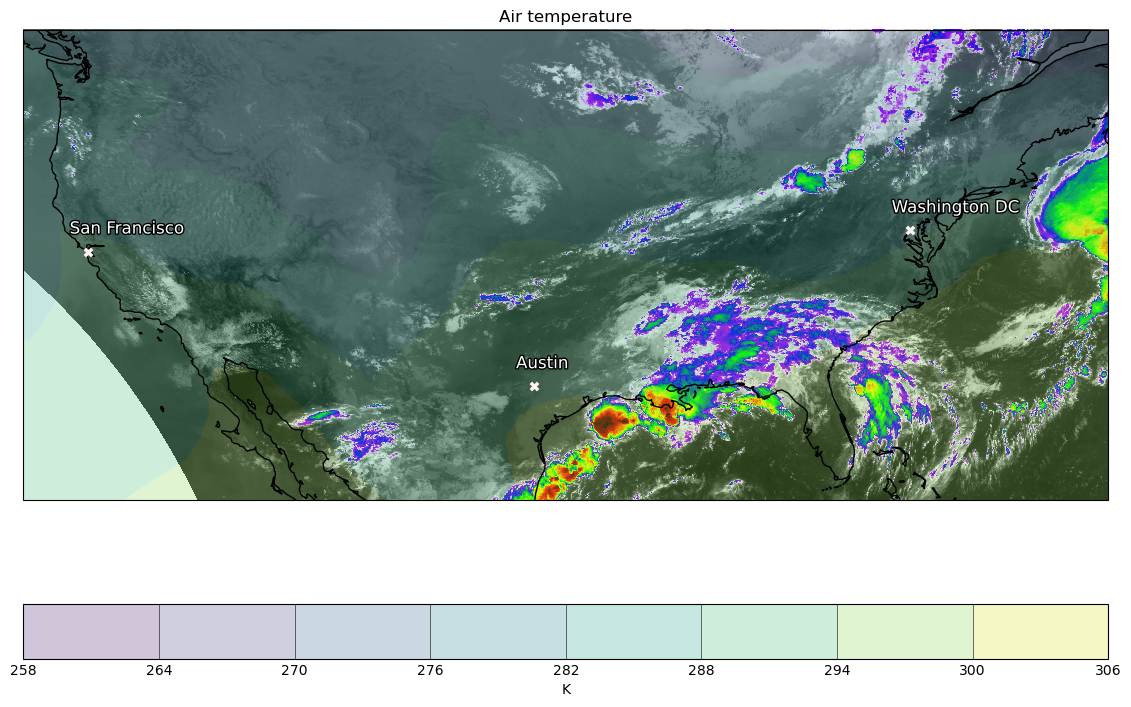

In [7]:
# Set up the axes, add a WMS layer and city locations; all as above.
proj = ccrs.PlateCarree()
ax = set_up_axes(proj, coast_colour='k')

ax.add_wms(url, layer)

for name, latlon in cities.items():
    plt.scatter(latlon[1], latlon[0], c=city_white, s=50, linewidths=0, marker='X', zorder = 99)
    plt.text(latlon[1]-1.0, latlon[0]+1.0, name, color='w', size=12,
             path_effects=[mpath.withStroke(linewidth=2, foreground='k')])
    
# Add the average air temperature data to the plot as a filled contour.
qplt.contourf(cube, alpha=0.25)

plt.show()

### Transforming WMS layers ###

Iris can re-project WMS layers into a projection that is not the native projection of the WMS response images. To demonstrate this, let's take the example from above of the WMS image; the cities; and the Iris air temperature data, and re-project it.

We know from the get capabilities request for this layer that its native CRS is EPSG-4326 (WGS-84), or Plate Carr&eacute;e. Let's use Cartopy to transform it into the [Lambert Conformal Conic](http://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) projection. 

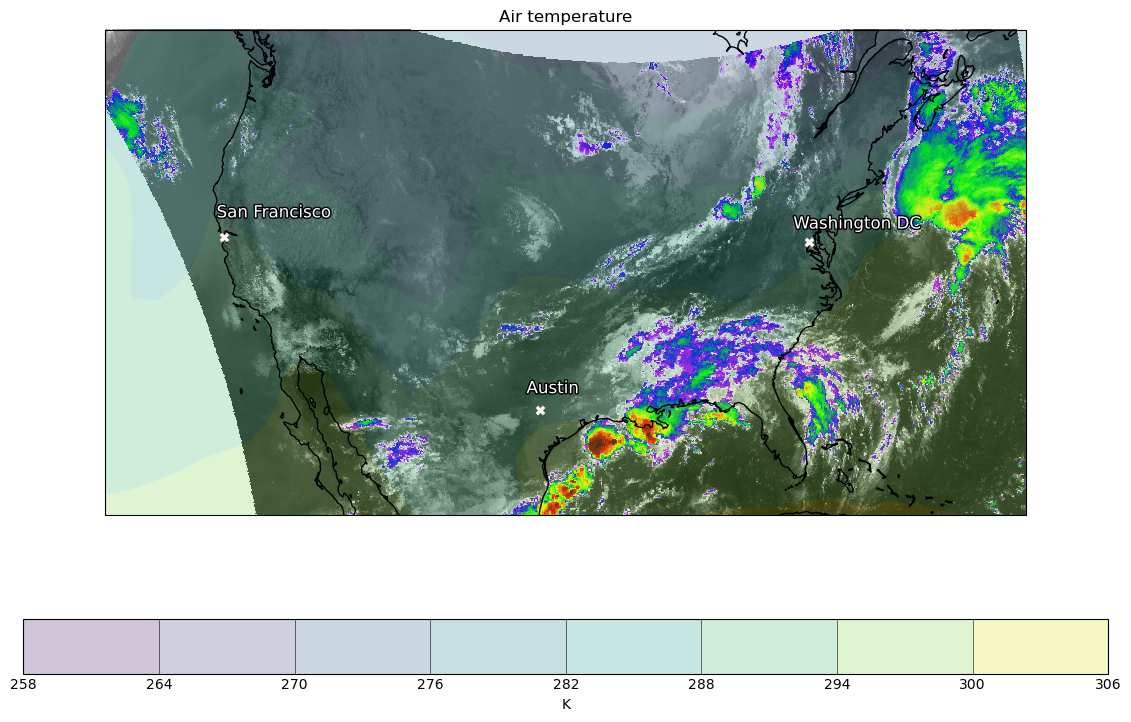

In [8]:
proj = ccrs.LambertConformal()
ax = set_up_axes(proj, coast_colour='k')

ax.add_wms(url, layer)

# Now that we've changed projection we need to specify the native projection
# of our city locations.
for name, latlon in cities.items():
    plt.scatter(latlon[1], latlon[0],
                c=city_white, s=50, linewidths=0, marker='X', zorder=99,
                transform=ccrs.PlateCarree())
    plt.text(latlon[1]-1.0, latlon[0]+1.0, name, color='w', size=12,
             path_effects=[mpath.withStroke(linewidth=2, foreground='k')],
             transform=ccrs.PlateCarree())

qplt.contourf(cube, alpha=0.25)

plt.show()